In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [22]:
# ======================
# 2. Генерация данных
# ======================
def generate_data(n_samples=1000, noise_level=0.1):
    """Генерация данных с добавлением шума"""
    np.random.seed(42)
    X = np.random.rand(n_samples, 2)  # значения в [0, 1]
    y = X[:, 0] * X[:, 1] + np.random.randn(n_samples) * noise_level
    return X, y

X, y = generate_data(noise_level=0.05)  # 5% шума
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# ======================
# 3. Определение функций принадлежности
# ======================
class GaussianMF(nn.Module):
    def __init__(self, mu, sigma):
        super().__init__()
        self.mu = nn.Parameter(torch.tensor(mu, dtype=torch.float32))
        self.sigma = nn.Parameter(torch.tensor(sigma, dtype=torch.float32))
    
    def forward(self, x):
        return torch.exp(-((x - self.mu)**2) / (2 * self.sigma**2 + 1e-6))

In [24]:
# ======================
# 4. Архитектура ANFIS
# ======================
class ANFIS(nn.Module):
    def __init__(self, n_inputs, n_mfs):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        
        # Инициализация функций принадлежности
        self.mfs = nn.ModuleList()
        for i in range(n_inputs):
            centers = np.linspace(0, 1, n_mfs[i])
            layer = nn.ModuleList([GaussianMF(mu=c, sigma=0.2) for c in centers])
            self.mfs.append(layer)
        
        # Параметры правил
        from itertools import product
        self.rule_indices = list(product(*[range(m) for m in n_mfs]))
        n_rules = len(self.rule_indices)
        self.p = nn.Parameter(torch.randn(n_rules))
        self.q = nn.Parameter(torch.randn(n_rules))
        self.r = nn.Parameter(torch.randn(n_rules))
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Вычисление степеней принадлежности
        mu_list = []
        for i in range(self.n_inputs):
            xi = x[:, i].unsqueeze(1)
            mus = torch.cat([mf(xi) for mf in self.mfs[i]], dim=1)
            mu_list.append(mus)
        
        # Вычисление весов правил
        W = []
        for idx in self.rule_indices:
            w = mu_list[0][:, idx[0]]
            for i in range(1, self.n_inputs):
                w = w * mu_list[i][:, idx[i]]
            W.append(w.unsqueeze(1))
        W = torch.cat(W, dim=1)
        
        # Нормализация весов
        W_sum = W.sum(dim=1, keepdim=True) + 1e-6
        W_norm = W / W_sum
        
        # Вычисление выходов правил
        f = torch.zeros(batch_size, len(self.rule_indices))
        for i, idx in enumerate(self.rule_indices):
            f[:, i] = self.p[i] * x[:, 0] + self.q[i] * x[:, 1] + self.r[i]
        
        # Итоговый выход
        return (W_norm * f).sum(dim=1)

In [25]:
# ======================
# 5. Инициализация модели
# ======================
model = ANFIS(n_inputs=2, n_mfs=[2, 2])  # 3 ФП на каждый вход
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # + регуляризация
criterion = nn.MSELoss()


In [26]:
# ======================
# 6. Обучение модели
# ======================
n_epochs = 150
train_losses = []
test_losses = []

# Конвертация данных в тензоры
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test).float()

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    
    # Оценка на тестовом наборе
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_t)
        test_loss = criterion(test_outputs, y_test_t)
    
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch 10/150, Train Loss: 0.0502, Test Loss: 0.0596
Epoch 20/150, Train Loss: 0.0455, Test Loss: 0.0488
Epoch 30/150, Train Loss: 0.0288, Test Loss: 0.0326
Epoch 40/150, Train Loss: 0.0227, Test Loss: 0.0244
Epoch 50/150, Train Loss: 0.0172, Test Loss: 0.0185
Epoch 60/150, Train Loss: 0.0135, Test Loss: 0.0147
Epoch 70/150, Train Loss: 0.0108, Test Loss: 0.0116
Epoch 80/150, Train Loss: 0.0088, Test Loss: 0.0093
Epoch 90/150, Train Loss: 0.0073, Test Loss: 0.0077
Epoch 100/150, Train Loss: 0.0063, Test Loss: 0.0065
Epoch 110/150, Train Loss: 0.0055, Test Loss: 0.0057
Epoch 120/150, Train Loss: 0.0049, Test Loss: 0.0051
Epoch 130/150, Train Loss: 0.0045, Test Loss: 0.0046
Epoch 140/150, Train Loss: 0.0042, Test Loss: 0.0043
Epoch 150/150, Train Loss: 0.0040, Test Loss: 0.0040



Final Test MSE: 0.00404, RMSE: 0.06355


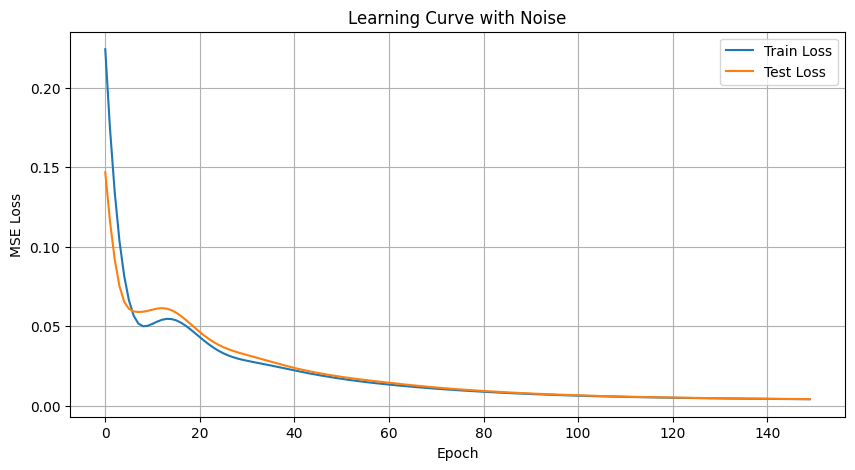

In [33]:
# ======================
# 7. Оценка и визуализация
# ======================
# Оценка качества
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_t).numpy()

mse_test = np.mean((y_test - y_test_pred)**2)
rmse_test = np.sqrt(mse_test)
print(f"\nFinal Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}")

# Визуализация кривой обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curve with Noise')
plt.legend()
plt.grid()
plt.show()


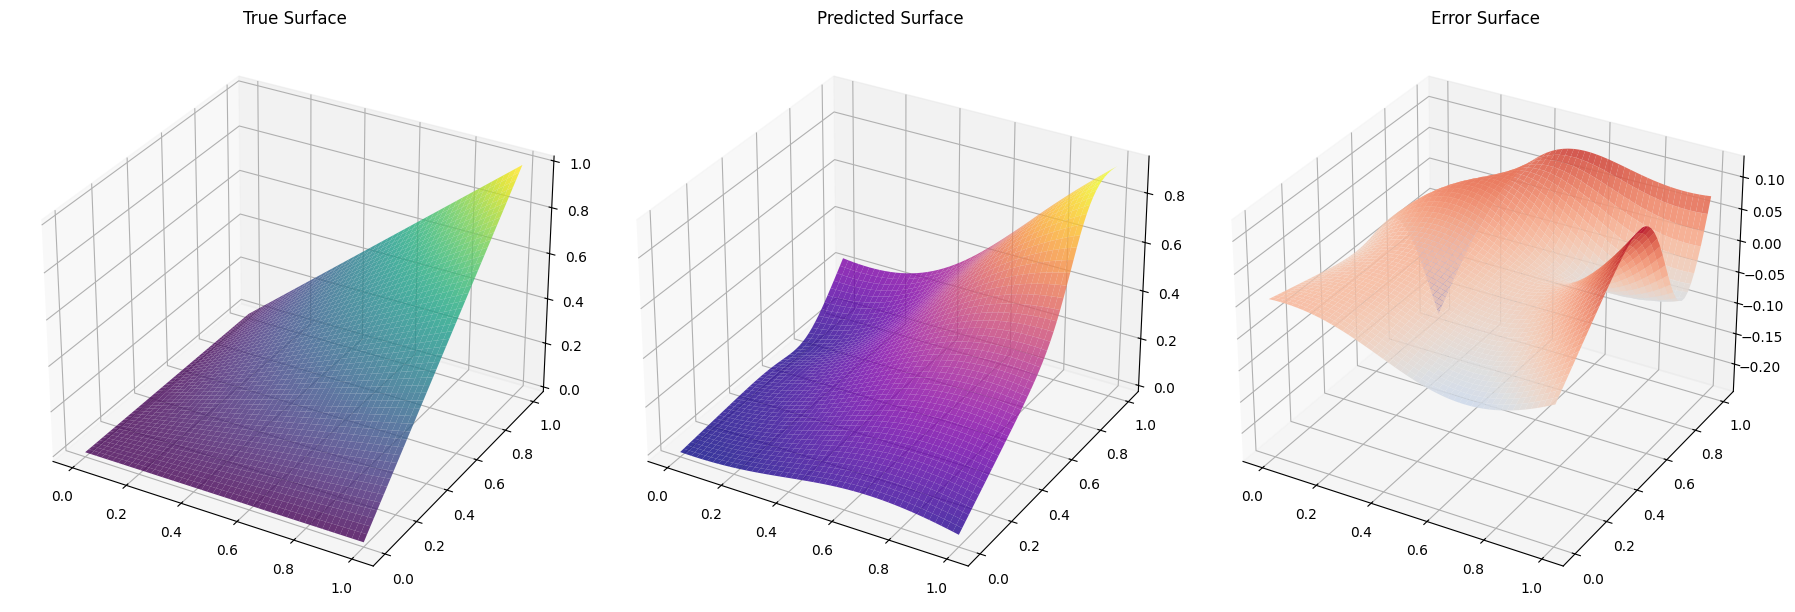

In [32]:
def plot_3d_comparison(model, true_func):
    # Подготовка сетки
    grid_size = 50
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Истинные значения
    Z_true = true_func(X, Y)
    
    # Предсказания
    XY = np.stack([X.ravel(), Y.ravel()], axis=1)
    with torch.no_grad():
        Z_pred = model(torch.FloatTensor(XY)).numpy().reshape(grid_size, grid_size)
    
    # 3D визуализация
    fig = plt.figure(figsize=(18, 6))
    
    # Истинная поверхность
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, Y, Z_true, cmap='viridis', alpha=0.8)
    ax1.set_title('True Surface')
    
    # Предсказанная поверхность
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, Y, Z_pred, cmap='plasma', alpha=0.8)
    ax2.set_title('Predicted Surface')
    
    # Ошибки
    ax3 = fig.add_subplot(133, projection='3d')
    error = Z_true - Z_pred
    ax3.plot_surface(X, Y, error, cmap='coolwarm', alpha=0.9)
    ax3.set_title('Error Surface')
    
    plt.tight_layout()
    plt.show()

# Использование:
plot_3d_comparison(model, lambda x, y: x * y)

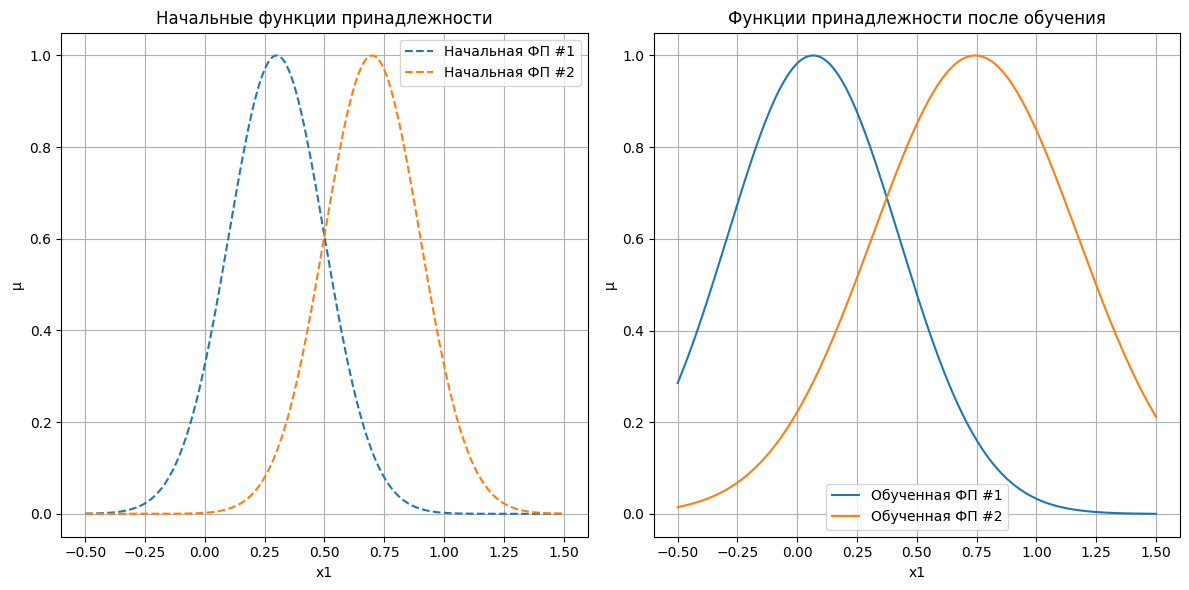

In [34]:
# 7.3. Визуализация ФП до и после обучения (для первого входа)
plt.figure(figsize=(12, 6))

# 1. Создаем начальные ФП для сравнения
initial_mfs = [GaussianMF(mu=0.3, sigma=0.2), 
               GaussianMF(mu=0.7, sigma=0.2)]  # Пример начальных параметров

# 2. Оптимальный диапазон для визуализации
x_grid = torch.linspace(-0.5, 1.5, 200).unsqueeze(1)  # Чуть шире рабочего диапазона

# 3. Визуализация начальных ФП
plt.subplot(1, 2, 1)
for idx, mf in enumerate(initial_mfs):
    y_before = mf(x_grid).detach().cpu().numpy().flatten()
    plt.plot(x_grid.cpu().numpy(), y_before, '--', label=f"Начальная ФП #{idx+1}")
plt.xlabel('x1')
plt.ylabel('μ')
plt.title('Начальные функции принадлежности')
plt.legend()
plt.grid(True)

# 4. Визуализация обученных ФП
plt.subplot(1, 2, 2)
for idx, mf in enumerate(model.mfs[0]):
    y_after = mf(x_grid).detach().cpu().numpy().flatten()
    plt.plot(x_grid.cpu().numpy(), y_after, label=f"Обученная ФП #{idx+1}")
plt.xlabel('x1')
plt.ylabel('μ')
plt.title('Функции принадлежности после обучения')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()